In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import gc
import os
import datetime

kernel_start_time = datetime.datetime.now()
# data path
train_path = '../pubg-finish-placement-prediction/train_V2.csv'
test_path = '../pubg-finish-placement-prediction/test_V2.csv'

print(os.listdir("../pubg-finish-placement-prediction"))

['.ipynb_checkpoints', 'pareto.html', 'PUBG Project.ipynb', 'PUBG_EDA.ipynb', 'sample_submission_V2.csv', 'test_V2.csv', 'train_player.csv', 'train_V2.csv']


In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    #print('{')
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        
        col_type = str(df[col].dtype)
        if col_type == 'object':
            col_type = 'str'
        else:
            col_type = 'np.' + col_type    
        #print('\'' + col + '\':' + col_type + ',')
    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    #print('}')
    return df

In [3]:
# optimal column data types
data_types = {'Id':str,'groupId':str,'matchId':str,'assists':np.int8,'boosts':np.int8,'damageDealt':np.float16,'DBNOs':np.int8,
'headshotKills':np.int8,'heals':np.int8,'killPlace':np.int8,'killPoints':np.int16,'kills':np.int8,'killStreaks':np.int8,'longestKill':np.float16,
'matchDuration':np.int16,'matchType':str,'maxPlace':np.int8,'numGroups':np.int8,'rankPoints':np.int16,'revives':np.int8,'rideDistance':np.float16,
'roadKills':np.int8,'swimDistance':np.float16,'teamKills':np.int8,'vehicleDestroys':np.int8,'walkDistance':np.float16,'weaponsAcquired':np.int16,
'winPoints':np.int16,'winPlacePerc':np.float16}

data_types['walkDistance'] = np.float32
data_types['rideDistance'] = np.float32
data_types['damageDealt'] = np.float32

In [4]:
# most useless features that was determined by others
zero_stdev_cols = ['median_match_roadKills', 'median_match_vehicleDestroys', 'median_match_road_kills_per_rideDistance', 'std_match_longestKill']
ulesess_stat_cols = ['median_match_revives','median_match_teamKills','median_match_swimDistance_norm',
'max_match_kill_streak_rate','max_group_roadKills','min_group_roadKills','median_match_assists',
'sum_group_roadKills','sum_group_vehicleDestroys','min_group_vehicleDestroys']
useless_match_type_names = ['normal-duo','flarefpp','normal-solo','crashtpp','normal-squad','flaretpp','normal-duo-fpp',
                           'normal-squadfpp', 'normal-squad-fpp', 'crashfpp','duo','squad-fpp','normal-solo-fpp']

all_useless_cols = zero_stdev_cols + ulesess_stat_cols + useless_match_type_names
all_useless_cols = set(all_useless_cols)

min_match_useful_cols = ['min_match_rankPoints', 'min_match_winPoints', 'min_match_killPoints']

In [5]:
# replace missing ranks
def fix_missing_ranks(X, mean_ranks=None, rank_stds=None, rank_cols=['rankPoints', 'winPoints']):
    if (mean_ranks is None) or (rank_stds is None):
        mean_ranks = {}
        rank_stds = {}

        for rank_col in rank_cols:
            mean_ranks[rank_col] = X.loc[X[rank_col] > 1, rank_col].mean()
            rank_stds[rank_col] = X.loc[X[rank_col] > 1, rank_col].std()
    
    # deviation from the mean value expressed in number of standard deviations
    rank_deltas = (X.loc[(X['rankPoints'] > 1) & (X['winPoints'] <= 1), 'rankPoints'] - mean_ranks['rankPoints']) / rank_stds['rankPoints']
    X.loc[(X['rankPoints'] > 1) & (X['winPoints'] <= 1), 'winPoints'] = mean_ranks['winPoints'] + rank_stds['winPoints']*rank_deltas
    
    win_deltas = (X.loc[(X['rankPoints'] <= 1) & (X['winPoints'] > 1), 'winPoints'] - mean_ranks['winPoints']) / rank_stds['winPoints']
    X.loc[(X['rankPoints'] <= 1) & (X['winPoints'] > 1), 'rankPoints'] = mean_ranks['rankPoints'] + rank_stds['rankPoints']*win_deltas
    
    X.loc[(X['rankPoints'] <= 1) & (X['winPoints'] <= 1), 'rankPoints'] = mean_ranks['rankPoints']
    X.loc[(X['rankPoints'] <= 1) & (X['winPoints'] <= 1), 'winPoints'] = mean_ranks['winPoints']

    return X, mean_ranks, rank_stds

In [6]:
# add basic player-level features by combining other features together
def add_player_features(X):
    X['headshot_rate'] = X['headshotKills'] / (X['kills'] + 0.00001)                    #暴頭率
    X['kill_streak_rate'] = X['killStreaks'] / (X['kills'] + 0.00001)                   #連續擊殺率
    X['kills_assists'] = X['kills'] + X['assists']                                      #助殺總和
    X['heals_boosts'] = X['heals'] + X['boosts']                                        #使用補給+提速次數
    X['total_distance'] = X['walkDistance'] + X['rideDistance'] + X['swimDistance']     #總移動次數
    X['kills_assists_per_heal_boost'] = X['kills_assists'] / (X['heals_boosts'] + 1)    #助殺/補給+提速
    X['damageDealt_per_heal_boost'] = X['damageDealt'] / (X['heals_boosts'] + 1)        #總傷害/補給+提速
    X['road_kills_per_rideDistance'] = X['roadKills'] / (X['rideDistance'] + 0.01)      #車上擊殺比
    X['maxPlace_per_numGroups'] = X['maxPlace'] / X['numGroups']                        #分組排名
    X['assists_per_kill'] = X['assists'] / (X['kills'] + X['assists'] + 0.0001)         #助殺比
    X['killPlace'] = X['killPlace'] - 1
    return X

In [7]:
# create some group-level features
# also creates some additional player-based features
def create_basic_group_info(X):
    group_cols = ['matchId', 'groupId', 'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'maxPlace_per_numGroups', 'winPlacePerc', 'killPlace']
    if 'winPlacePerc' not in X.columns:
        group_cols.remove('winPlacePerc')
        
    pl_data_grouped = X[group_cols].groupby(['matchId', 'groupId'])
    gr_data = pl_data_grouped.first()
    gr_data.drop(columns='killPlace', inplace=True)
    
    gr_data['raw_groupSize'] = pl_data_grouped['numGroups'].count()
    gr_data['groupSize'] = gr_data['raw_groupSize']
    gr_data['group_size_overflow'] = (gr_data['groupSize'] > 4).astype(np.int8)
    gr_data.loc[gr_data['groupSize'] > 4, ['groupSize']] = 2 # replace group sizes with median, since it's a bug, max group size is 4
    
    
    gr_data['meanGroupSize'] = gr_data.groupby('matchId')['groupSize'].transform(np.mean)
    gr_data['medianGroupSize'] = gr_data.groupby('matchId')['groupSize'].transform(np.median)
    #gr_data['maxGroupSize'] = gr_data.groupby('matchId')['groupSize'].transform(np.max)
    #gr_data['minGroupSize'] = gr_data.groupby('matchId')['groupSize'].transform(np.min)
    gr_data['maxKillPlace'] = pl_data_grouped['killPlace'].max().groupby('matchId').transform(np.max)
    
    gr_data['totalPlayers'] = gr_data.groupby('matchId')['groupSize'].transform(sum)
    # some matches have missing players, so I adjust the total number of players to account for that
    gr_data['totalPlayersAdjusted'] = gr_data['maxPlace'].astype(float) * gr_data['totalPlayers'] / (gr_data['numGroups'] + 0.01)
    # trim total number to 100 as it can't be higher than that 
    gr_data['totalPlayersAdjusted'] = gr_data['totalPlayersAdjusted'].apply(lambda x: np.minimum(100.0, x))
    #gr_data.drop(columns=['totalPlayers'], inplace=True)
    gr_data['num_opponents'] = gr_data['totalPlayersAdjusted'] - gr_data['groupSize']
    
    X = X.merge(gr_data[['num_opponents', 'totalPlayersAdjusted', 'groupSize', 'raw_groupSize', 'maxKillPlace']], on=['matchId', 'groupId'])
    
    print('group size counts:')
    print(X['raw_groupSize'].value_counts())
    
    # normalizing some features
    X['revives_per_groupSize'] = X['revives'] / (X['groupSize'] - 1 + 0.001)
    X['kills_assists_norm_both'] = X['kills_assists'].astype(np.float32) / X['num_opponents'] / X['matchDuration']
    
    X['killPlace_norm'] = X['killPlace']/ (X['maxKillPlace'] + 0.000001)
    
    #X['kills_assists_norm_opp_n'] = X['kills_assists'].astype(np.float32) / X['num_opponents']
    #X['kills_assists_norm_dur'] = X['kills_assists'].astype(np.float32) / X['matchDuration']
    X['damageDealt_norm_both'] = X['damageDealt'].astype(np.float32) / X['num_opponents'] / X['matchDuration']
    #X['damageDealt_norm_opp_n'] = X['damageDealt'].astype(np.float32) / X['num_opponents']
    #X['damageDealt_norm_dur'] = X['damageDealt'].astype(np.float32) / X['matchDuration']
    X['DBNOs_norm'] = X['DBNOs'].astype(np.float32) / X['num_opponents'] / X['matchDuration']
    X['heals_norm'] = X['heals'].astype(np.float32) / X['matchDuration']
    X['boosts_norm'] = X['boosts'].astype(np.float32) / X['matchDuration'] # - lowers correlation, don't do
    X['walkDistance_norm'] = X['walkDistance'].astype(np.float32) / X['matchDuration']
    X['rideDistance_norm'] = X['rideDistance'].astype(np.float32) / X['matchDuration']
    X['swimDistance_norm'] = X['swimDistance'].astype(np.float32) / X['matchDuration']
    
    #gr_data.drop(columns=['groupSize'], inplace=True)
    
    gr_data = reduce_mem_usage(gr_data)
    gr_data.drop(columns=list(set(gr_data.columns)&all_useless_cols))
    return gr_data, X

In [8]:
# create group- and match- level stat features. Merge all useful features together while removing useless ones.
def create_group_and_match_stats(data, gr_data):
    
    group_stats_cols = ['assists','boosts','DBNOs','killPoints','longestKill','rankPoints', 'road_kills_per_rideDistance',
                        'kills_assists_norm_both', 'damageDealt_norm_both', 'DBNOs_norm', 'heals_boosts', 'assists_per_kill', 'killPlace_norm',
                        'revives','roadKills','teamKills','vehicleDestroys','weaponsAcquired','winPoints','headshot_rate','kill_streak_rate',
                        'kills_assists', 'heals_norm','walkDistance_norm','rideDistance_norm','swimDistance_norm',
                       'damageDealt_per_heal_boost','kills_assists_per_heal_boost']
    # removed damageDealt
    match_stats_cols = ['assists','boosts','DBNOs','killPoints','longestKill','rankPoints', 'road_kills_per_rideDistance',
                        'kills_assists_norm_both', 'damageDealt_norm_both', 'DBNOs_norm', 'heals_boosts', 'assists_per_kill',
                        'revives','roadKills','teamKills','vehicleDestroys','weaponsAcquired','winPoints','headshot_rate','kill_streak_rate',
                        'kills_assists', 'heals_norm','walkDistance_norm','rideDistance_norm','swimDistance_norm',
                       'damageDealt_per_heal_boost','kills_assists_per_heal_boost']
    
    pl_data_grouped_by_group = data.groupby(['matchId', 'groupId'])
    pl_data_grouped_by_match = data.groupby(['matchId'])

    #group_sizes = pl_data_grouped_by_group['groupSize'].count().values.reshape([-1])
    #fixed_group_sizes = pl_data_grouped_by_group['groupSize'].first().values.reshape([-1])
    #sum_multipliers = fixed_group_sizes.astype(np.float32) / group_sizes
    #print('min multiplier: {:.2f}, max multiplier: {:.2f}'.format(np.min(sum_multipliers), np.max(sum_multipliers)))
    #print('min group size: {:d}, max group size: {:d}'.format(np.min(group_sizes), np.max(group_sizes)))
    #print('min fixed group size: {:d}, max fixed group size: {:d}'.format(np.min(fixed_group_sizes), np.max(fixed_group_sizes)))
    #print(pd.Series(sum_multipliers).value_counts())
    
    group_funcs = {'min':np.min, 'max':np.max, 'sum':np.sum, 'median': np.mean}
    match_funcs = {'min':np.min,'max':np.max, 'sum':np.sum, 'median': np.median, 'std':np.std}
    extra_group_stats = pl_data_grouped_by_group[['matchId', 'groupId']].first().reset_index(drop=True)
    extra_match_stats = pl_data_grouped_by_match[['matchId']].first().reset_index(drop=True)    

    for colname in group_stats_cols:
        for f_name, func in group_funcs.items():
            gr_col_name = f_name + '_group_' + colname
            if (gr_col_name not in all_useless_cols) or ((gr_col_name + '_rank') not in all_useless_cols):
                if func is not sum:
                    extra_group_stats[gr_col_name] = pl_data_grouped_by_group[colname].agg(func).values
                else:
                    extra_group_stats[gr_col_name] = pl_data_grouped_by_group[colname].agg(func).values * sum_multipliers
    
    for colname in match_stats_cols:    
        for f_name, func in match_funcs.items():
            m_col_name = f_name + '_match_' + colname
            if m_col_name not in all_useless_cols:
                if func is np.std:
                    extra_match_stats[m_col_name] = pl_data_grouped_by_match[colname].agg(func).fillna(0).values
                elif func is np.min:
                    if m_col_name in min_match_useful_cols:
                        extra_match_stats[m_col_name] = pl_data_grouped_by_match[colname].agg(func).values
                else:
                    extra_match_stats[m_col_name] = pl_data_grouped_by_match[colname].agg(func).values
            
            
    extra_group_stats.set_index(['matchId', 'groupId'], inplace=True)
    extra_match_stats.set_index(['matchId'], inplace=True)

    pl_data_grouped_by_group = None
    pl_data_grouped_by_match = None

    select_cols = []
    for col in extra_group_stats.columns:
        if ((col + '_rank') not in all_useless_cols) and (col not in ['matchId', 'groupId']):
            select_cols.append(col)
    
    # adding rank information
    rank_data = extra_group_stats.groupby(['matchId'])
    rank_data = rank_data[select_cols].rank() - 1 # method='dense'
    gc.collect()
    max_rank_data = rank_data.groupby(['matchId']).transform(np.max)
    rank_data = rank_data / (max_rank_data + 0.0001)
    max_rank_data = None
    gc.collect()
    print('rank data created')
    
    gr_col_to_drop = list(set(extra_group_stats.columns) & all_useless_cols)
    extra_group_stats.drop(columns=gr_col_to_drop, inplace=True)
    gc.collect()

    extra_group_stats = extra_group_stats.join(rank_data, on=['matchId', 'groupId'], rsuffix='_rank')
    extra_group_stats.reset_index(level=1, inplace=True) # put groupId back into the columns

    rank_data = None
    gc.collect()
    print('rank data merged')
    extra_group_stats = reduce_mem_usage(extra_group_stats)
    extra_match_stats = reduce_mem_usage(extra_match_stats)

    merged_features = extra_group_stats.merge(extra_match_stats, on=['matchId'])
    extra_group_stats = None
    extra_match_stats = None
    gc.collect()
    print('extra match and group stats merged')
    merged_features = merged_features.merge(gr_data, on=['matchId', 'groupId'])
    gr_data = None
    gc.collect()
    print('group data and stats merged')
    
    #one hot encoding of match type
    cats = merged_features['matchType'].unique()
    cats = set(cats) - set(all_useless_cols)
    encoded_data = np.empty(shape=(merged_features.shape[0], 0), dtype=np.int8)
    for category in cats:
        encoded_data = np.c_[encoded_data, (merged_features[['matchType']] == category).values.reshape(-1,1).astype(np.int8)]
    encoded_data = pd.DataFrame(encoded_data, columns=cats, index=merged_features.index, dtype=np.int8)
    print('matchType data created')
    for col in encoded_data.columns:
        merged_features[col] = encoded_data[col]
    encoded_data = None
    gc.collect()
    print('match type data merged')
#    cols_to_drop = ['matchType']
#    merged_features = merged_features.drop(columns=cols_to_drop)
    
    return merged_features

In [9]:
# remove outliers. Also returns data for the outliers. Maye I need to keep them...
def remove_outliers(X):
    outliers = (X['walkDistance'] > 10000) | (X['rideDistance'] > 15000) | (X['swimDistance'] > 1000) | ((X['kills'] > 0) & (X['total_distance'] == 0))
    outliers = outliers | (X['kills'] > 30) | (X['longestKill'] > 800) | (X['weaponsAcquired'] > 40)
    X = X.loc[~outliers]
    outlier_data = X.loc[outliers]
    return X, outlier_data

In [10]:
# pipeline for processing the datasets:
# use fit_transform to prepare the training data
# use transform to prepare the test data. It will use some data calculated in fit_transform.
class DataPipeline():
    def __init__(self, pipeline=None):
        if pipeline is not None:
            self.rank_means = pipeline.rank_means
            self.rank_stds = pipeline.rank_stds
        return
    
    def fit_transform(self, data_path):
        data = pd.read_csv(data_path)
        
        # reduce memory usage
        for col_name, col_type in data_types.items():
            data[col_name] = data[col_name].astype(col_type)
        
        # remove crappy data or missing one
        data = data.loc[~data['winPlacePerc'].isna()]
        data = data.loc[data['maxPlace'] > 1]
        
        # remove too large groups
        #group_sizes = data.groupby(['matchId', 'groupId'])[['maxPlace']].count()
        #group_sizes.columns = ['groupSize']
        #data = data.merge(group_sizes, on=['groupId', 'matchId'])
        #data = data.loc[data['groupSize'] <= 8]
        #data.drop(columns=['groupSize'], inplace=True)
        #group_sizes = None
        
        data, self.rank_means, self.rank_stds = fix_missing_ranks(data)
        data = add_player_features(data)
        gr_data, data = create_basic_group_info(data)
        
        #data = remove_outliers(data)[0]
        # drop 7 columns
#        cols_to_drop = ['kills', 'headshotKills', 'killStreaks', 'walkDistance', 'rideDistance', 'swimDistance', 'heals']
#        data.drop(columns=cols_to_drop, inplace=True)
        data_ids = data[['Id', 'matchId', 'groupId']]
        
        # generate and combine all features
        merged_features = create_group_and_match_stats(data, gr_data)

        # removing columns with zero stdev
        #cols_to_remove = []
        #for col in merged_features.columns:
        #    if col != 'winPlacePerc':
        #        min_val = merged_features[col].min()
        #        max_val = merged_features[col].max()
        #        if min_val == max_val:
        #            cols_to_remove.append(col)
        #            merged_features.drop(columns=col)
        #            print('dropped column: ' + col)
        #self.cols_to_remove = cols_to_remove
        gc.collect()
        print('final feature dataframe shape:', merged_features.shape)
        
        return merged_features.reset_index(), data_ids
    
    def transform(self, data_path):
        data = pd.read_csv(data_path)
        
        # reduce memory usage
        for col_name, col_type in data_types.items():
            if col_name != 'winPlacePerc':
                data[col_name] = data[col_name].astype(col_type)
        
        data = fix_missing_ranks(data, self.rank_means, self.rank_stds)[0]
        data = add_player_features(data)
        gr_data, data = create_basic_group_info(data)
        
        # drop 7 columns
#        cols_to_drop = ['kills', 'headshotKills', 'killStreaks', 'walkDistance', 'rideDistance', 'swimDistance', 'heals']
#        data.drop(columns=cols_to_drop, inplace=True)
        data_ids = data[['Id', 'matchId', 'groupId']]
        
        # generate and combine all features
        merged_features = create_group_and_match_stats(data, gr_data)

        # removing columns with zero stdev
        #for col in self.useless_cols:
        #    merged_features.drop(columns=col, inplace=True)
        #    gc.collect()  
        print('final feature dataframe shape:', merged_features.shape)
        return merged_features.reset_index(), data_ids

In [11]:
gc.collect()
pipeline = DataPipeline()
train, initial_ids = pipeline.fit_transform(train_path)

group size counts:
2     1308422
4      870160
1      792276
3      741411
5      267130
6      155250
7      103516
8       67376
9       43488
10      29350
11      19932
12      13608
13      10556
14       7868
15       5145
16       3664
17       2618
18       2016
19       1159
20        440
22        374
21        357
23        161
26        130
74         74
72         72
24         72
64         64
28         56
27         54
25         50
49         49
36         36
31         31
Name: raw_groupSize, dtype: int64
rank data created
rank data merged
extra match and group stats merged
group data and stats merged
matchType data created
match type data merged
final feature dataframe shape: (2026744, 341)


# player 層的資料

In [16]:
validation = train.sample(frac=0.2,random_state=11,axis=0)
training=train.loc[~train.index.isin(validation.index)]
print(validation.shape, training.shape)

#training.to_csv("train_group.csv", index=False, sep = ',')
#validation.to_csv("val_group.csv", index=False, sep = ',')


(405349, 342) (1621395, 342)


In [17]:
# pipeline for processing the datasets:
# use fit_transform to prepare the training data
# use transform to prepare the test data. It will use some data calculated in fit_transform.
class DataPipeline2():
    def __init__(self, pipeline=None):
        if pipeline is not None:
            self.rank_means = pipeline.rank_means
            self.rank_stds = pipeline.rank_stds
        return
    
    def fit_transform(self, data_path):
        data = pd.read_csv(data_path)
        
        # reduce memory usage
        for col_name, col_type in data_types.items():
            data[col_name] = data[col_name].astype(col_type)
        
        # remove crappy data or missing one
        data = data.loc[~data['winPlacePerc'].isna()]
        data = data.loc[data['maxPlace'] > 1]
        
        # remove too large groups
        #group_sizes = data.groupby(['matchId', 'groupId'])[['maxPlace']].count()
        #group_sizes.columns = ['groupSize']
        #data = data.merge(group_sizes, on=['groupId', 'matchId'])
        #data = data.loc[data['groupSize'] <= 8]
        #data.drop(columns=['groupSize'], inplace=True)
        #group_sizes = None
        
        data, self.rank_means, self.rank_stds = fix_missing_ranks(data)
        data = add_player_features(data)
#        gr_data, data = create_basic_group_info(data)
        
        #data = remove_outliers(data)[0]
        # drop 7 columns
#        cols_to_drop = ['kills', 'headshotKills', 'killStreaks', 'walkDistance', 'rideDistance', 'swimDistance', 'heals']
#        data.drop(columns=cols_to_drop, inplace=True)
        data_ids = data[['Id', 'matchId', 'groupId']]
        
        # generate and combine all features
#        merged_features = create_group_and_match_stats(data, gr_data)

        # removing columns with zero stdev
        #cols_to_remove = []
        #for col in merged_features.columns:
        #    if col != 'winPlacePerc':
        #        min_val = merged_features[col].min()
        #        max_val = merged_features[col].max()
        #        if min_val == max_val:
        #            cols_to_remove.append(col)
        #            merged_features.drop(columns=col)
        #            print('dropped column: ' + col)
        #self.cols_to_remove = cols_to_remove
        gc.collect()
        print('final feature dataframe shape:', data.shape)
        
        return data.reset_index(), data_ids
    
gc.collect()
pipeline = DataPipeline2()
train, initial_ids = pipeline.fit_transform(train_path)

final feature dataframe shape: (4446965, 39)


# group 層的資料(筆數會不一樣，因為把player層的變數刪掉了)

In [18]:
validation = train.sample(frac=0.2,random_state=11,axis=0)
training=train.loc[~train.index.isin(validation.index)]
print(validation.shape, training.shape)

training.to_csv("train_player.csv", index=False, sep = ',')
validation.to_csv("val_player.csv", index=False, sep = ',')


(889393, 40) (3557572, 40)


## 後面是產test的變數跟建模，可以不用管

In [17]:
# standard normalization in a memory-efficient way
mean_vals = pd.Series()
std_vals = pd.Series()

for num, col in enumerate(train.columns):
    if col not in ['winPlacePerc', 'groupId', 'matchId']:
        train[col] = train[col].astype(np.float32)
        mean = train[col].mean()
        stdev = train[col].std()
        if stdev == 0:
            train.drop(columns=col, inplace=True)
            #print(num, 'drop column:\t', col)
        else:
            train[col] = ((train[col] - mean)/stdev).astype(np.float32)
            #print(num, '\tname', col, 'mean', mean, 'stdev', stdev)
            mean_vals[col] = mean
            std_vals[col] = stdev
        gc.collect()

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [19]:
trainX = train.drop(columns=['winPlacePerc', 'matchId', 'groupId'])
trainY = train['winPlacePerc']
regr = LinearRegression()
regr.fit(trainX, trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
test, test_ids = pipeline.transform(test_path)

# standard normalization in a memory-efficient way
for num, col in enumerate(test.columns):
    if col not in ['winPlacePerc', 'groupId', 'matchId']:
        test[col] = test[col].astype(np.float32)
        test[col] = ((test[col] - mean_vals[col])/std_vals[col]).astype(np.float32)
        gc.collect()

group size counts:
2     577918
4     376884
1     347393
3     318084
5     115840
6      67314
7      43442
8      28744
9      18684
10     12060
11      8459
12      5868
13      4264
14      2912
15      2130
16      1504
17       850
18       576
19       361
20       220
21       189
23       138
22       110
63        63
26        52
25        50
35        35
30        30
Name: raw_groupSize, dtype: int64
rank data created
rank data merged
extra match and group stats merged
group data and stats merged
matchType data created
match type data merged
final feature dataframe shape: (886238, 339)


In [25]:
# The coefficients
print('Coefficients: \n', regr.coef_)

y_pred = regr.predict(trainX)


# The mean squared error
print('Mean absolute error: %.2f'
      % mean_absolute_error(trainY, y_pred))

Coefficients: 
 [-2.13278132e-03  1.22847408e-03  2.64616497e-03 -2.31061969e-03
 -1.16752870e-02 -3.35658621e-03  5.24108391e-03  3.04058306e-02
 -4.69704252e-03 -7.79252313e-03 -1.16858762e-02  1.35911573e-02
 -1.42813884e-02 -1.79372411e-02  8.67178664e-04 -1.90367606e-02
  9.67647880e-04 -8.91102850e-03  6.32998720e-03  9.85800754e-03
  1.00069623e-02 -7.08997250e-04  4.20800924e+00 -3.39662656e-03
  5.56508487e-04 -4.00042114e+01  4.00044365e+01 -9.51212365e-04
  2.40237918e-03 -3.31045501e-03  2.95322039e-03 -2.21119029e-03
 -6.02302328e-03 -2.21276283e-03  4.97102737e-05  2.42614746e-02
  1.34587288e-04  2.04086304e-04  3.03459167e-03 -7.61032104e-04
 -5.12260199e-03  8.43489170e-03 -9.11116600e-03 -1.21608973e-02
 -9.53435898e-04 -4.33301926e-03 -3.48782539e-03  5.16948104e-02
  6.48727417e-02  5.13792038e-03 -1.23773813e-02 -1.00354761e-01
  6.86645508e-05 -1.42717361e-03  3.02553177e-03  1.16205215e-03
  8.25727358e-04 -4.17947769e-04  1.62124634e-05 -6.34193420e-04
 -1.32179

In [34]:
coef = pd.Series(regr.coef_)
print(coef[26])
coef.sort_values()


148.2629


25    -148.262634
22     -14.707886
243    -10.553083
127     -5.018126
325     -4.704236
          ...    
180      3.367136
179      5.022173
244     10.552320
69      19.387705
26     148.262894
Length: 338, dtype: float32

In [38]:
train['min_group_road_kills_per_rideDistance']

0         -0.002165
1         -0.002165
2         -0.002165
3         -0.002165
4         -0.002165
             ...   
2026739   -0.002165
2026740   -0.002165
2026741   -0.002165
2026742   -0.002165
2026743   -0.002165
Name: min_group_road_kills_per_rideDistance, Length: 2026744, dtype: float32

In [20]:
# memory-efficient function to feed train and validation data into the neural net
def get_data_batch(batch_size, randomize=False):
    if randomize:
        curr_idx = np.random.permutation(train.shape[0])
    else:
        curr_idx = range(train.shape[0])
    for batch_n in range(int(np.ceil(train.shape[0] / batch_size))):
        batch_data = train.iloc[curr_idx[batch_n*batch_size:(batch_n+1)*batch_size]]
        group_sizes = batch_data['groupSize'].values*std_vals['groupSize'] + mean_vals['groupSize']
        yield batch_data.drop(columns=['winPlacePerc', 'matchId', 'groupId']).values, batch_data['winPlacePerc'].values, group_sizes

In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#from tensorflow.python.framework import ops
tf.reset_default_graph()

dropout_rate = [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5]

def leaky_relu(z, name=None):
    return tf.maximum(0.01*z, z, name=name)

dynamic_dropout = tf.placeholder_with_default(0.5, shape=(None), name='dynamic_dropout')

X = tf.placeholder(dtype=tf.float32, shape=[None, train.shape[1]-3], name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None), name='y')
group_sizes = tf.placeholder(dtype=tf.float32, shape=(None), name='group_sizes')

#X_conv = tf.reshape(X[:,:144], shape=[-1, 2, 72, 1])
#X_rest = X[:,144:]

training = tf.placeholder_with_default(False, shape=(None), name='training') 

with tf.name_scope('layers') as scope:
    #X_drop = tf.layers.dropout(X, rate=dropout_rate[0], training=training, name='input_dropout')

    hidden1 = tf.layers.dense(X, 100, name='hidden1',
                             kernel_initializer=tf.variance_scaling_initializer())
    hidden1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9, name='hidden1_bn')
    #hidden1 = leaky_relu(hidden1, name='hidden1_activation')
    hidden1 = tf.nn.elu(hidden1, name='hidden1_activation')
    #hidden1 = tf.layers.dropout(hidden1, rate=dropout_rate[1], training=training, name='dropout1')
    
    hidden2 = tf.layers.dense(hidden1, 60, name='hidden2',
                             kernel_initializer=tf.variance_scaling_initializer())
    hidden2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9, name='hidden2_bn')
    #hidden2 = leaky_relu(hidden2, name='hidden2_activation')
    hidden2 = tf.nn.elu(hidden2, name='hidden2_activation')
    #hidden2 = tf.layers.dropout(hidden2, rate=dropout_rate[2], training=training, name='dropout2')
    
    
    hidden3 = tf.layers.dense(hidden2, 60, name='hidden3',
                             kernel_initializer=tf.variance_scaling_initializer())
    hidden3 = tf.layers.batch_normalization(hidden3, training=training, momentum=0.9, name='hidden3_bn')
    hidden3 = tf.nn.elu(hidden3, name='hidden3_activation')
    #hidden3 = leaky_relu(hidden3, name='hidden3_activation')
    #hidden3 = tf.layers.dropout(hidden3, rate=dropout_rate[3], training=training, name='dropout3')
    
    hidden4 = tf.layers.dense(hidden3, 60, name='hidden4',
                             kernel_initializer=tf.variance_scaling_initializer())
    hidden4 = tf.layers.batch_normalization(hidden4, training=training, momentum=0.9, name='hidden4_bn')
    hidden4 = tf.nn.elu(hidden4, name='hidden4_activation')
    #hidden4 = leaky_relu(hidden4, name='hidden4_activation')
    #hidden4 = tf.layers.dropout(hidden4, rate=dropout_rate[4], training=training, name='dropout4')
    
    hidden5 = tf.layers.dense(hidden4, 60, name='hidden5',
                             kernel_initializer=tf.variance_scaling_initializer())
    hidden5 = tf.layers.batch_normalization(hidden5, training=training, momentum=0.9, name='hidden5_bn')
    hidden5 = tf.nn.elu(hidden5, name='hidden5_activation')
    #hidden5 = leaky_relu(hidden5, name='hidden5_activation')
    hidden5 = tf.layers.dropout(hidden5, rate=dropout_rate[5], training=training, name='dropout5')
    
    #hidden6 = tf.layers.dense(hidden5, 30, name='hidden6',
    #                         kernel_initializer=tf.variance_scaling_initializer())
    #hidden6 = tf.layers.batch_normalization(hidden6, training=training, momentum=0.9, name='hidden6_bn')
    #hidden6 = tf.nn.elu(hidden6, name='hidden5_activation')
    #hidden6 = tf.layers.dropout(hidden6, rate=dropout_rate[6], training=training, name='dropout6')
    
    output = tf.layers.dense(hidden5, 1, name='output',
                             kernel_initializer=tf.variance_scaling_initializer())

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.dropout instead.


In [22]:
with tf.name_scope('loss') as scope:
    # MSE is the loss here, although the final score is determined based on MAE
    diff_vector = tf.abs(tf.reshape(output, shape=[-1]) - y)
    sum_group_sizes = tf.reduce_sum(group_sizes)
    loss_mse = tf.reduce_sum(tf.square(diff_vector)*group_sizes)/sum_group_sizes
    loss_mae = tf.reduce_sum(diff_vector*group_sizes)/sum_group_sizes
    clipped_diff_vector = tf.clip_by_value(diff_vector, 0.0, 1.0)
    lin_err = 2*(diff_vector - clipped_diff_vector)
    loss_hybrid = tf.reduce_sum((tf.square(clipped_diff_vector) + lin_err)*group_sizes)/sum_group_sizes
    #loss_hybrid = tf.reduce_mean(tf.square(clipped_diff_vector) + lin_err)

with tf.name_scope('training') as scope:
    lr_high = 0.0008
    lr_low = 0.00001
    learning_rate = tf.Variable(0.0001, trainable=False, name='learning_rate')
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.6)
    training_op = optimizer.minimize(loss_hybrid)

val_batch_size = 10000

def get_mse_mae(sess, batch_size=10000):
    y_diffs = np.empty(shape=0)
    curr_group_sizes = np.empty(shape=0)
    for X_batch, y_batch, batch_gr_sizes in get_data_batch(batch_size=batch_size):
        curr_output_vals = sess.run(output, feed_dict = {X:X_batch}).reshape(-1)
        y_diffs = np.r_[y_diffs, np.abs(y_batch - curr_output_vals)]
        curr_group_sizes = np.r_[curr_group_sizes, batch_gr_sizes]
    loss_mae_val = np.sum(y_diffs*curr_group_sizes)/np.sum(curr_group_sizes)
    loss_mse_val = np.sum((y_diffs**2)*curr_group_sizes)/np.sum(curr_group_sizes)
    #loss_mae_val = np.mean(y_diffs)
    #loss_mse_val = np.mean(y_diffs**2)
    return loss_mse_val, loss_mae_val
    
extra_training_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [23]:
gc.collect()

batch_size = 5000
n_epochs = 1000
max_epochs_wo_improvement = 50
max_epochs_wo_lr_change = 10
max_time = 2 # hours

loss_data = {'mse_train':[], 'mae_train':[], 'lr':[]}

start_time = datetime.datetime.now()

def get_dropout(initial_dropout, epoch):
    return np.maximum(0, initial_dropout*(1 - epoch/200))

with tf.Session() as sess:
    init.run()
    min_loss_mae = np.inf
    epochs_wo_improvement = 0
    epochs_since_lr_change = 0
    batch_lr = lr_high
    
    for epoch in range(n_epochs):
        for X_batch, y_batch, batch_gr_sizes in get_data_batch(batch_size=batch_size, randomize=True):
            feed_dict = {X: X_batch, y: y_batch, training:True, learning_rate:batch_lr, group_sizes:batch_gr_sizes}
            sess.run([training_op, extra_training_ops], feed_dict=feed_dict)

        loss_mse_train, loss_mae_train = get_mse_mae(sess)
        loss_data['mse_train'].append(loss_mse_train)
        loss_data['mae_train'].append(loss_mae_train)
        loss_data['lr'].append(batch_lr)
        
        print('epoch', epoch, 'time passed:', (datetime.datetime.now() - start_time), 'learning rate: {:<5.5f}'.format(batch_lr)) #'learning rate:', sess.run(learning_rate))
        print('MSE:', loss_mse_train, 'MAE:', loss_mae_train)
        
        if loss_mae_train <= min_loss_mae:
            epochs_wo_improvement = 0
            epochs_since_lr_change = 0
            min_loss_mae = loss_mae_train
            save_path = saver.save(sess, '../DNN_data/dnn_state.ckpt')
            print('- best so far!')
        else:
            epochs_wo_improvement += 1
            epochs_since_lr_change += 1
        
            if (epochs_wo_improvement > max_epochs_wo_improvement) or ((datetime.datetime.now() - start_time).seconds > max_time*60*60):
                print('early breaking!')
                break

            if epochs_since_lr_change >= max_epochs_wo_lr_change:
                    batch_lr = batch_lr - (batch_lr - lr_low)*0.3
                    epochs_since_lr_change = 0
                    #saver.restore(sess, save_path)

    saver.restore(sess, save_path)
    loss_mse_val, loss_mae_val = get_mse_mae(sess)
    print('Final MSE:', loss_mse_val, 'final MAE:', loss_mae_val)

epoch 0 time passed: 0:01:00.948714 learning rate: 0.00080
MSE: 0.008018778052332434 MAE: 0.05416659787021723
- best so far!
epoch 1 time passed: 0:01:46.968838 learning rate: 0.00080
MSE: 0.005612559530347474 MAE: 0.046151338380465395
- best so far!
epoch 2 time passed: 0:02:33.194618 learning rate: 0.00080
MSE: 0.0036661710199647184 MAE: 0.040466215903835624
- best so far!
epoch 3 time passed: 0:03:18.331998 learning rate: 0.00080
MSE: 0.002631912861258773 MAE: 0.03670272475561764
- best so far!
epoch 4 time passed: 0:04:03.211206 learning rate: 0.00080
MSE: 0.00265916234217273 MAE: 0.03769774225276624
epoch 5 time passed: 0:04:47.897109 learning rate: 0.00080
MSE: 0.0027527709690116134 MAE: 0.03858513223463189
epoch 6 time passed: 0:05:32.858703 learning rate: 0.00080
MSE: 0.0023919344379898315 MAE: 0.03528955148205418
- best so far!
epoch 7 time passed: 0:06:17.708080 learning rate: 0.00080
MSE: 0.0022648047054920134 MAE: 0.03462678092704208
- best so far!
epoch 8 time passed: 0:07

epoch 71 time passed: 0:55:29.232628 learning rate: 0.00080
MSE: 0.0014909922706496808 MAE: 0.02732352799687905
epoch 72 time passed: 0:56:13.973540 learning rate: 0.00080
MSE: 0.0015865276841155753 MAE: 0.027843141599187136
epoch 73 time passed: 0:56:58.988856 learning rate: 0.00056
MSE: 0.0015821029705818904 MAE: 0.029355106580357625
epoch 74 time passed: 0:57:44.784561 learning rate: 0.00056
MSE: 0.0014578958348657864 MAE: 0.026336427800440876
- best so far!
epoch 75 time passed: 0:58:30.316262 learning rate: 0.00056
MSE: 0.0014311783149431351 MAE: 0.026798128857533906
epoch 76 time passed: 0:59:16.296059 learning rate: 0.00056
MSE: 0.001522796926537822 MAE: 0.02903493035804957
epoch 77 time passed: 1:00:01.338789 learning rate: 0.00056
MSE: 0.0014473159118587185 MAE: 0.027198647110705857
epoch 78 time passed: 1:00:46.354913 learning rate: 0.00056
MSE: 0.001616974919351834 MAE: 0.030749548340757032
epoch 79 time passed: 1:01:31.308250 learning rate: 0.00056
MSE: 0.001606610824769985

epoch 143 time passed: 1:49:04.689227 learning rate: 0.00020
MSE: 0.0013995664252116837 MAE: 0.027712870477281725
epoch 144 time passed: 1:49:49.060193 learning rate: 0.00020
MSE: 0.0015481613567893255 MAE: 0.03003624248059486
epoch 145 time passed: 1:50:33.757579 learning rate: 0.00020
MSE: 0.0013980369196113984 MAE: 0.027592222970991093
epoch 146 time passed: 1:51:18.267795 learning rate: 0.00020
MSE: 0.0013541002584220117 MAE: 0.026347099833891222
epoch 147 time passed: 1:52:02.703089 learning rate: 0.00020
MSE: 0.0014317250309003123 MAE: 0.027483330418340918
epoch 148 time passed: 1:52:46.958571 learning rate: 0.00014
MSE: 0.0013395448637239847 MAE: 0.02579046420322644
epoch 149 time passed: 1:53:31.269640 learning rate: 0.00014
MSE: 0.0013938246526998207 MAE: 0.027516733953468663
epoch 150 time passed: 1:54:15.354434 learning rate: 0.00014
MSE: 0.0013582189805227704 MAE: 0.026351913624093195
epoch 151 time passed: 1:54:59.568482 learning rate: 0.00014
MSE: 0.001349090189401578 MAE

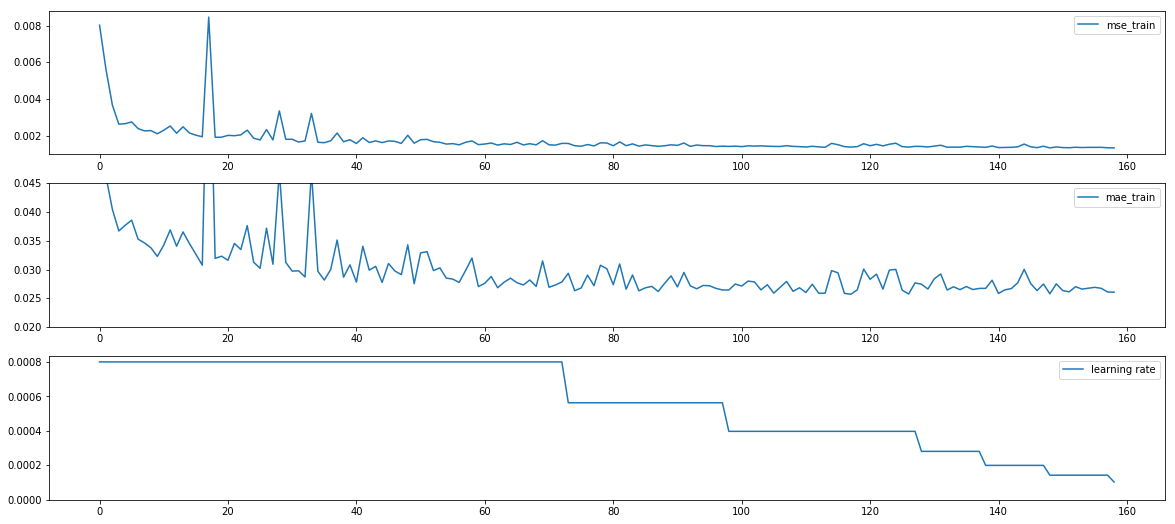

In [39]:
# plot MAE and MSE vs. epoch
plt.figure(figsize=[20,9])
plt.subplot(3,1,1)
plt.plot(loss_data['mse_train'], label='mse_train')
plt.legend()

plt.subplot(3,1,2)
plt.plot(loss_data['mae_train'], label='mae_train')
plt.ylim([0.02,0.045])
#plt.ylim([0,plt.ylim()[1]])
plt.legend()

plt.subplot(3,1,3)
plt.plot(loss_data['lr'], label='learning rate')
plt.ylim([0,plt.ylim()[1]])
plt.legend()

plt.show()

In [40]:
# Drop all match-level stats.
# Train another neural net that 2 groups from the same match and tries to predict which group has a higher score

group_cols = [col for col in train.columns if re.search(r'group', col) is not None]
group_cols = [col for col in group_cols if re.search(r'_rank', col) is None]
group_cols.remove('groupId')
other_cols = [col for col in train.columns if re.search(r'match|group', col) is None]
other_cols.remove('num_opponents')
other_cols.remove('winPlacePerc')

In [41]:
def get_match_comp_indices(x, gaps):
    gap_lim = x.shape[0]
    gaps = [gap for gap in gaps if gap < gap_lim]
    if len(gaps) > 0:
        x = x.sort_values(by=['winPlacePerc'])
        results = []
        for gap in gaps:
            result = np.empty(shape=[x.shape[0]-gap, 2], dtype=np.int32)
            result[:,0] = np.array(x.iloc[gap:].index).astype(np.int32)
            result[:,1] = np.array(x.iloc[:-gap].index).astype(np.int32)
            results.append(result)
        return np.vstack(results)
    else:
        return np.empty(shape=[0,2], dtype=np.int32)

def get_comparator_indices(X, gap=1):
    result = X[['matchId', 'winPlacePerc']].groupby(['matchId']).apply(lambda x: get_match_comp_indices(x, gap))
    print('stage 1 complete')
    result = np.concatenate(result, axis=0)
    return result

In [42]:
# For training I select groups that are winthin 4 winPlacePerc ranks.
gaps = [i for i in range(1, 4)]
train_comp_inds = get_comparator_indices(train, gaps)

train_array = train.drop(columns=['matchId', 'groupId', 'winPlacePerc']).values

group_col_inds = [train.columns.drop(['matchId', 'groupId', 'winPlacePerc']).get_loc(col) for col in group_cols]
other_col_inds = [train.columns.drop(['matchId', 'groupId', 'winPlacePerc']).get_loc(col) for col in other_cols]

def get_comp_batch(inds, batch_size, omit_last=True):
    rand_inds = np.random.permutation(inds.shape[0])
    if omit_last:
        func = np.floor
    else:
        func = np.ceil
    for batch_n in range(int(func(inds.shape[0]/batch_size))):
        batch_inds = inds[rand_inds[batch_n*batch_size:(batch_n+1)*batch_size]]
        X1_batch = train_array[batch_inds[:,0]][:,group_col_inds]
        X2_batch = train_array[batch_inds[:,1]][:,group_col_inds]
        X3_batch = train_array[batch_inds[:,0]][:,other_col_inds]
        yield X1_batch, X2_batch, X3_batch

stage 1 complete


In [50]:
dropout_rate = [0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.2, 0.2]
layer_sizes = [100, 100, 60, 60, 60, 30, 30, 30]

tf.reset_default_graph()

def leaky_relu(z, name=None):
    return tf.maximum(0.01*z, z, name=name)

#X = tf.placeholder(dtype=tf.float32, shape=[None, (len(group_cols)*2 + len(other_cols))], name='X')
#X = tf.placeholder(dtype=tf.float32, shape=[None, (len(group_cols) + len(other_cols)), 2], name='X')
X1 = tf.placeholder(dtype=tf.float32, shape=[None, len(group_cols)], name='X1')
X2 = tf.placeholder(dtype=tf.float32, shape=[None, len(group_cols)], name='X2')
X3 = tf.placeholder(dtype=tf.float32, shape=[None, len(other_cols)], name='X3')

X = tf.concat([tf.concat([X1, X2, X3], axis=1), tf.concat([X2, X1, X3], axis=1)], axis=0)

y = tf.placeholder(dtype=tf.float32, shape=(None), name='y')
y_all = tf.concat([y, 1-y], axis=0)

training = tf.placeholder_with_default(False, shape=(None), name='training') 

with tf.name_scope('layers') as scope:
    hidden = tf.layers.dropout(X, rate=dropout_rate[0], training=training, name='input_dropout')
    
    for i in range(8):
        hidden = tf.layers.dense(hidden, layer_sizes[i], name=f'hidden_{i}',
                                 kernel_initializer=tf.glorot_uniform_initializer())
        hidden = tf.layers.batch_normalization(hidden, training=training, momentum=0.9, name=f'hidden_{i}_bn')
        hidden = tf.nn.elu(hidden, name=f'hidden_{i}_activation')
        hidden = leaky_relu(hidden, name=f'hidden_{i}_activation')
        hidden = tf.layers.dropout(hidden, rate=dropout_rate[i], training=training, name=f'dropout_{i}')
       
    logits = tf.layers.dense(hidden, 1, name='logits',
                             kernel_initializer= tf.glorot_uniform_initializer())
    output = tf.nn.sigmoid(logits, name='output')

In [51]:
with tf.name_scope('loss') as scope:
    # MSE is the loss here, although the final score is determined based on MAE
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_all,logits=tf.reshape(logits, [-1]),name='xentropy')
    loss = tf.reduce_mean(xentropy)

with tf.name_scope('training') as scope:
    #global_step = tf.train.global_step()
    lr_low = 0.00001
    lr_high = 0.003
    lr_high_2 = 0.0003
    decay_rate = 15
    lr = tf.Variable(lr_high, trainable=False, name='learning_rate')
    optimizer = tf.train.AdamOptimizer(learning_rate=lr, epsilon=1e-10)
    #grads_and_vars = optimizer.compute_gradients(loss_mse)
    #gradients = [grad for grad, var in grads_and_vars]
    #names = [var.name for grad, var in grads_and_vars]
    training_op = optimizer.minimize(loss)

with tf.name_scope('evaluation') as scope:
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.reshape(output,[-1])),y_all), tf.float32), name='accuracy')

def get_full_set_accuracy(sess, inds, batch_size=1000):
    y_batch = np.ones(shape=[batch_size])
    y_for_comp = np.r_[y_batch, 1 - y_batch]
    acc_data = np.empty(shape=0)
    for X1_batch, X2_batch, X3_batch in get_comp_batch(inds=inds, batch_size=batch_size):
        #X1_batch = train.loc[batch_inds[:,0], group_cols].values
        #X2_batch = train.loc[batch_inds[:,1], group_cols].values
        #X3_batch = train.loc[batch_inds[:,0], other_cols].values
        feed_dict = {X1:X1_batch, X2:X2_batch, X3:X3_batch, y:y_batch}
        y_pred = sess.run(output, feed_dict=feed_dict).reshape(-1)
        batch_acc_data = ((y_pred > 0.5).astype(np.float32) == y_for_comp).astype(np.float32)
        acc_data = np.r_[acc_data, batch_acc_data]
    return np.mean(acc_data)
    
extra_training_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

init = tf.global_variables_initializer()
saver_comp = tf.train.Saver()

In [52]:
import gc
import datetime
gc.collect()

batch_size = 500
n_epochs = 1000
max_epochs_without_improving = 50
max_epochs_wo_lr_change = 7
max_time = 5.5

acc_data = {'acc_train':[], 'acc_val':[]}
batch_acc_data = []
batch_lr_data = []

start_time = datetime.datetime.now()

with tf.Session() as sess:
    init.run()
    max_val_acc = 0
    epochs_wo_improvement = 0
    epochs_since_lr_update = 0
    gap = 1
    #batches_per_epoch = int(len(train_match_ids) / batch_size)
    #period = 1 # epochs
    #period_batches = period * batches_per_epoch
    batch_lr = lr_high
    y_batch = np.ones(shape=[batch_size])
    
    for epoch in range(n_epochs):
        n_batch = 0
        
        if epoch == 15:
            batch_size = 1000
            y_batch = np.ones(shape=[batch_size])
            max_epochs_without_improving = 100
            max_epochs_wo_lr_change = 10
        if epoch == 25:
            batch_size = 2000
            y_batch = np.ones(shape=[batch_size])
        if epoch == 40:
            batch_size = 4000
            y_batch = np.ones(shape=[batch_size])
            max_epochs_wo_lr_change = 15
        if epoch == 60:
            batch_size = 8000
            y_batch = np.ones(shape=[batch_size])
            max_epochs_wo_lr_change = 20
        
        #curr_lr_high = lr_high_2 + (lr_high-lr_high_2)*np.exp(-(epoch - (epoch%period))/decay_rate)
        for X1_batch, X2_batch, X3_batch in get_comp_batch(inds=train_comp_inds, batch_size=batch_size):
        #for X_batch, y_batch in get_comparator_batch_2(train, train_match_ids, batch_size, gap):
            #print(n_batch)
            #if n_batch > batches_per_epoch:
            #    batches_per_epoch = n_batch
                
            #curr_batch = (epoch % period)*batches_per_epoch + n_batch
            #coeff = curr_batch/period_batches
            #coeff = np.minimum(coeff, 1-coeff)
            #coeff = 2*np.clip(coeff, 0, 0.5)
            #batch_lr = lr_low + (curr_lr_high-lr_low)*(coeff)
            
            #print(X_batch.shape, y_batch.shape)
            
            #X1_batch = train.loc[inds[:,0], group_cols].values
            #X2_batch = train.loc[inds[:,1], group_cols].values
            #X3_batch = train.loc[inds[:,0], other_cols].values
            feed_dict = {X1:X1_batch, X2:X2_batch, X3:X3_batch, y:y_batch}
            
            batch_lr_data.append(batch_lr)
            batch_acc_data.append(sess.run(accuracy, feed_dict=feed_dict))
            
            feed_dict = {X1:X1_batch, X2:X2_batch, X3:X3_batch, y:y_batch, training:True, lr:batch_lr}
            sess.run([training_op, extra_training_ops], feed_dict=feed_dict)
            n_batch += 1
        if (epoch >= 20) and (epoch % 1 == 0):
            curr_ids = np.random.permutation(train_comp_inds.shape[0])[:100000]
            train_acc = get_full_set_accuracy(sess, train_comp_inds[curr_ids], batch_size=10000)
            #curr_ids = np.random.permutation(val_comp_inds.shape[0])[:10000]
            #val_acc = get_full_set_accuracy(sess, val_comp_inds[curr_ids], batch_size=1000)
            acc_data['acc_train'].append(train_acc)
            #acc_data['acc_val'].append(val_acc)

            print('epoch', epoch, 'time passed:', (datetime.datetime.now() - start_time), 'max lr:', batch_lr)
            print('Accuracy: train:', train_acc)

            if train_acc > max_val_acc:
                epochs_wo_improvement = 0
                epochs_since_lr_update = 0
                max_val_acc = train_acc
                save_path_comp = saver_comp.save(sess, '../DNN_data/dnn_state_comp.ckpt')
                print('- best so far!')
            else:
                epochs_wo_improvement += 1
                epochs_since_lr_update += 1
                
                if (epochs_wo_improvement > max_epochs_without_improving) or ((datetime.datetime.now() - kernel_start_time).seconds/60/60 > max_time):
                    print('early breaking!')
                    break
                
                if epochs_since_lr_update >= max_epochs_wo_lr_change:
                    batch_lr = batch_lr - (batch_lr-lr_high_2)*0.33
                    epochs_since_lr_update = 0
                    # restore the best state before lowering the learning rate
                    #saver_comp.restore(sess, save_path_comp)
                    
    saver_comp.restore(sess, save_path_comp)
    curr_ids = np.random.permutation(train_comp_inds.shape[0])[:100000]
    train_acc = get_full_set_accuracy(sess, train_comp_inds[curr_ids], batch_size=10000)
    #val_acc = get_full_set_accuracy(sess, val_match_ids[:10000], batch_size=1000, gap=1)
    print('Final accuracy: train:', train_acc)

epoch 20 time passed: 2:53:46.615496 max lr: 0.003
Accuracy: train: 0.87203
- best so far!
epoch 21 time passed: 3:01:24.511259 max lr: 0.003
Accuracy: train: 0.869885
early breaking!
INFO:tensorflow:Restoring parameters from ../DNN_data/dnn_state_comp.ckpt
Final accuracy: train: 0.87051


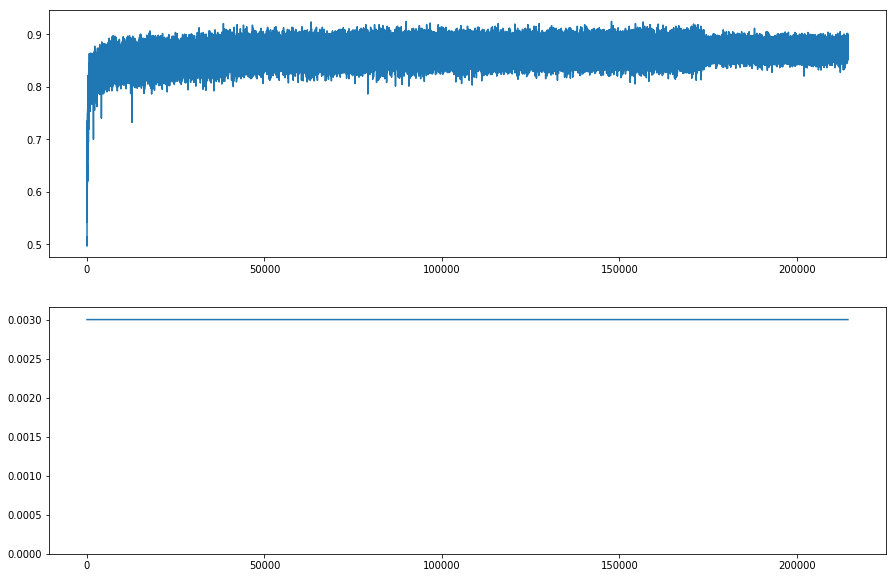

In [53]:
plt.figure(figsize=[15,10])
plt.subplot(2,1,1)
plt.plot(batch_acc_data)

plt.subplot(2,1,2)
plt.plot(batch_lr_data)
plt.ylim([0, plt.ylim()[1]])
plt.show()

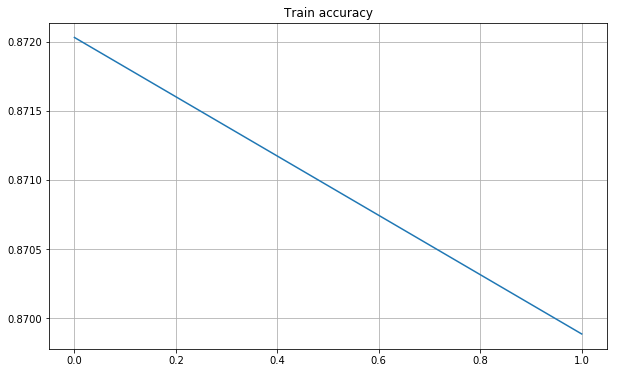

In [54]:
#plot accuracy vs batch number
plt.figure(figsize=[10,6])
plt.plot(acc_data['acc_train'])
plt.grid()
plt.title('Train accuracy') 
plt.show()

In [ ]:
# Step 4. Swap the groups' predicted winPlacePercs if the second neural net predicts that they should be swapped

In [55]:
# functions for generating data for the second DNN to rearrange the group placements
def generate_val_comp_data(X, gap):
    if X.shape[0] > gap:
        X = X.sort_values(by=['winPlacePerc'])
        group_data = X[group_cols].values
        part0 = X[['matchId', 'groupId']].values[gap:,:]
        part0 = np.c_[part0, X[['matchId', 'groupId']].values[:-gap,:]]
        part1 = group_data[gap:,:]
        part2 = group_data[:-gap,:]
        part3 = X[other_cols].values[:-gap,:]
        return part0, part1, part2, part3
    return np.empty(shape=(0, 4)), np.empty(shape=(0, len(group_cols))), np.empty(shape=(0, len(group_cols))), np.empty(shape=(0, len(other_cols)))

def get_val_batch(data, batch_size=1000, gap=1):
    matchIds = data['matchId'].unique().tolist()
    for i in range(int(np.ceil(len(matchIds)/batch_size))):
        match_ids_batch = matchIds[i*batch_size:(i+1)*batch_size]
        grouped_data = data.loc[data['matchId'].isin(match_ids_batch)].groupby('matchId').apply(lambda x: generate_val_comp_data(x, gap))
        part0, part1, part2, part3 = list(map(np.vstack, zip(*grouped_data)))
        yield part0, part1, part2, part3

In [56]:
# reorder the groups placement
def reorder_val(data, ids, y_comp_pred):    
    df = pd.DataFrame(np.c_[ids, y_comp_pred.reshape(-1,1)], columns=['matchId', 'groupId', 'ordered'])
    data = data.merge(df, on=['matchId', 'groupId'], how='left')
    data['ordered'].fillna(1, inplace=True)
    data.sort_values(by=['matchId','winPlacePerc'], inplace=True)
    zero_inds = np.nonzero(data['ordered'].values == 0)[0]
    
    i = 0
    old_order = []
    new_order = []
    wPP_col_num = data.columns.get_loc('winPlacePerc')
    while i < len(zero_inds):
        start = zero_inds[i]
        while (i+1 < len(zero_inds)) and (zero_inds[i+1] - zero_inds[i] == 1):
            i += 1
        end = zero_inds[i]
        length = end - start + 1
        i += 1
        old_order.extend([i for i in range(start-1, start+length, 1)])
        new_order.extend([i for i in range(start+length-1, start-2, -1)])
        
    data.iloc[old_order, wPP_col_num] = data.iloc[new_order, wPP_col_num].values

    print('rows swapped')
    data.drop(columns=['ordered'], inplace=True)
    
    return data

In [57]:
train = None
train_idx = None
train_ids = None
gc.collect()

6234

In [58]:
test, test_ids = pipeline.transform(test_path)

# standard normalization in a memory-efficient way
for num, col in enumerate(test.columns):
    if col not in ['winPlacePerc', 'groupId', 'matchId']:
        test[col] = test[col].astype(np.float32)
        test[col] = ((test[col] - mean_vals[col])/std_vals[col]).astype(np.float32)
        gc.collect()

group size counts:
2     577918
4     376884
1     347393
3     318084
5     115840
6      67314
7      43442
8      28744
9      18684
10     12060
11      8459
12      5868
13      4264
14      2912
15      2130
16      1504
17       850
18       576
19       361
20       220
21       189
23       138
22       110
63        63
26        52
25        50
35        35
30        30
Name: raw_groupSize, dtype: int64
rank data created
rank data merged
extra match and group stats merged
group data and stats merged
matchType data created
match type data merged
final feature dataframe shape: (886238, 339)


In [59]:
# y_val is a data frame containing columns: 
# [matchId, groupId, winPlacePerc, winPlacePerc_pred]
y_test_dnn = pd.DataFrame(np.zeros(shape=[1,3]), columns=['matchId', 'groupId', 'winPlacePerc_pred'])
predict_batch_size = 10000
tf.reset_default_graph()
saver = tf.train.import_meta_graph('../DNN_data/dnn_state.ckpt.meta')

X = tf.get_default_graph().get_tensor_by_name('X:0')
output = tf.get_default_graph().get_tensor_by_name('layers/output/BiasAdd:0')

init = tf.global_variables_initializer()


with tf.Session() as sess:
    init.run()
    saver.restore(sess, '../DNN_data/dnn_state.ckpt')
    n_batches = int(np.ceil(test.shape[0]/predict_batch_size))
    for batch_n in range(n_batches):
        data_batch = test.iloc[batch_n*predict_batch_size:(batch_n+1)*predict_batch_size]
        X_batch = data_batch.drop(columns=['matchId','groupId'])
        y_batch = data_batch[['matchId','groupId']]
        y_batch['winPlacePerc_pred'] = output.eval(session=sess, feed_dict={X: X_batch})
        y_test_dnn = y_test_dnn.append(y_batch, ignore_index=True)
y_test_dnn = y_test_dnn.iloc[1:,:]

INFO:tensorflow:Restoring parameters from ../DNN_data/dnn_state.ckpt


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
# aligning winPlacePerc based on the predicted rank and numGroups
def rank_align_predictions(X, y, scaled=False):
    X['winPlacePerc'] = y
    X['rank'] = X.groupby(['matchId'])['winPlacePerc'].rank(method='dense')
    X['max_rank'] = X.groupby(['matchId'])['rank'].transform(np.max)
    adj_winPlacePerc = (X['rank'] - 1) / (X['max_rank'] - 1 + 0.0000000001)
    X.drop(columns=['winPlacePerc', 'rank', 'max_rank'], inplace=True)
    return adj_winPlacePerc

#further align predictions based on maxPlace
def fix_predictions(X, y, scaled=False):
    y = y.copy()
    y[y > 1.0] = 1.0
    y[y < 0.0] = 0.0
    
    if scaled:
        max_places = X['maxPlace'].values*std_vals['maxPlace'] + mean_vals['maxPlace']
        num_groups = X['numGroups'].values*std_vals['numGroups'] + mean_vals['numGroups']
    else:
        max_places = X['maxPlace'].values
        num_groups = X['numGroups'].values
    
    multiplier = (max_places[max_places > 1] - 1).astype(np.float32)
    y[max_places > 1] = np.round(y[max_places > 1] * multiplier) / multiplier
    y[max_places == 1] = 1.0
    y[max_places <= 0] = 0.0
    y[num_groups <= 1] = 0.0

    return y

In [61]:
# align and fix predictions
y_test_dnn['winPlacePerc_pred'] = rank_align_predictions(y_test_dnn.drop(columns=['winPlacePerc_pred']), y_test_dnn['winPlacePerc_pred'])
y_test_dnn = y_test_dnn.merge(test[['matchId', 'groupId', 'numGroups', 'maxPlace']], on=['matchId', 'groupId'])
y_test_dnn['winPlacePerc_pred'] = fix_predictions(y_test_dnn.drop(columns=['winPlacePerc_pred']), y_test_dnn['winPlacePerc_pred'], scaled=True)

In [62]:
test = test.merge(y_test_dnn[['matchId', 'groupId', 'winPlacePerc_pred']], on=['matchId', 'groupId'])
test.rename(columns={'winPlacePerc_pred':'winPlacePerc'}, inplace=True)

In [63]:
n_epochs = 6
batch_size = 10000
comp_thresh = [-0.1, 0, -0.1]

y_comp_diff_data = {}
y_comp_pred_data = {}

tf.reset_default_graph()
saver_comp = tf.train.import_meta_graph('../DNN_data/dnn_state_comp.ckpt.meta')

X1 = tf.get_default_graph().get_tensor_by_name('X1:0')
X2 = tf.get_default_graph().get_tensor_by_name('X2:0')
X3 = tf.get_default_graph().get_tensor_by_name('X3:0')

output = tf.get_default_graph().get_tensor_by_name('layers/output:0')

init = tf.global_variables_initializer()

with tf.Session() as sess:
    saver_comp.restore(sess, save_path_comp)
    
    for epoch in range(n_epochs):
        y_comp_pred = np.empty(shape=[0])
        y_comp_diff = np.empty(shape=[0])
        all_ids = np.empty(shape=[0, 2])
        for batch_ids, X1_batch, X2_batch, X3_batch in get_val_batch(test, batch_size):
            feed_dict = {X1:X1_batch, X2:X2_batch, X3:X3_batch}
            batch_output = output.eval(feed_dict=feed_dict).reshape(-1)
            assert len(batch_output) % 2 ==0
            y_batch_pred = batch_output[:int(len(batch_output)/2)]
            y_batch_comp = batch_output[:int(len(batch_output)/2)] - batch_output[int(len(batch_output)/2):]
            
            y_comp_pred = np.r_[y_comp_pred, y_batch_pred]
            y_comp_diff = np.r_[y_comp_diff, y_batch_comp]
            all_ids = np.r_[all_ids, batch_ids[:,:2]]
        
        y_comp_pred_data[epoch] = y_comp_pred
        y_comp_diff_data[epoch] = y_comp_diff
        thresh_ind = np.minimum(len(comp_thresh)-1, epoch)
        y_comp_diff = y_comp_diff > comp_thresh[thresh_ind]
        print('epoch:', epoch, 'number of zeros:', len(np.nonzero(y_comp_diff == 0)[0]))
        
        if np.min(y_comp_diff) == 0:
            test = reorder_val(test, all_ids, y_comp_diff)
        else:
            break

INFO:tensorflow:Restoring parameters from ../DNN_data/dnn_state_comp.ckpt
epoch: 0 number of zeros: 110588
rows swapped
epoch: 1 number of zeros: 98931
rows swapped
epoch: 2 number of zeros: 24228
rows swapped
epoch: 3 number of zeros: 7560
rows swapped
epoch: 4 number of zeros: 2522
rows swapped
epoch: 5 number of zeros: 1000
rows swapped


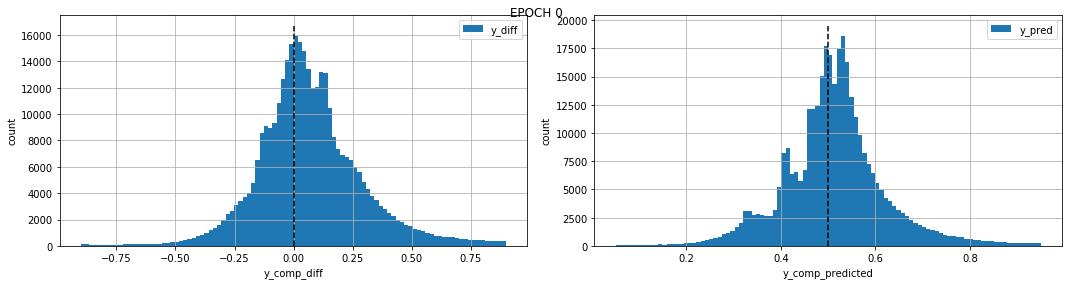

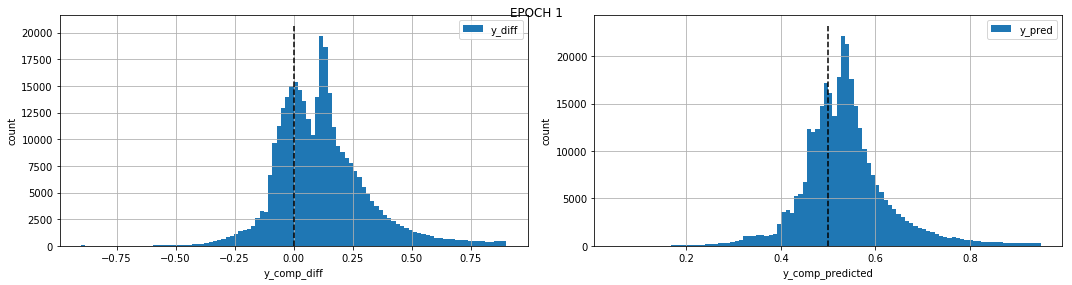

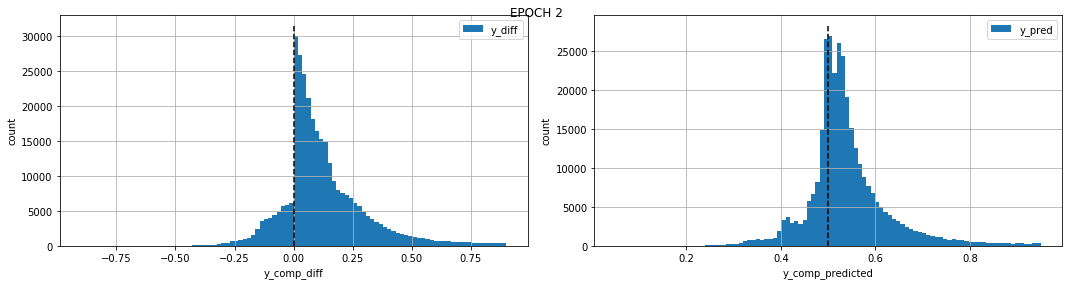

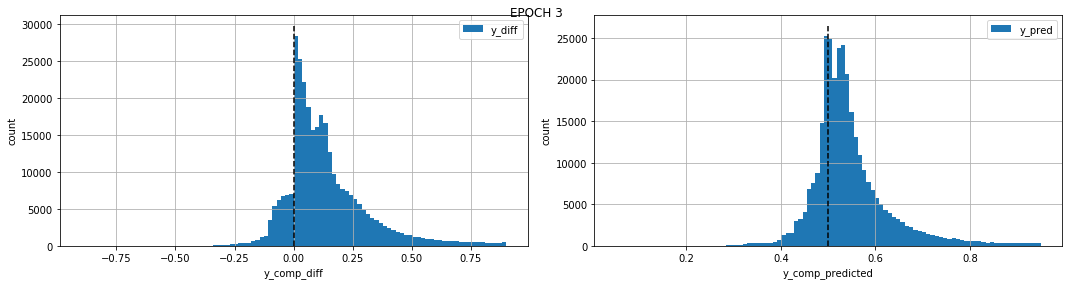

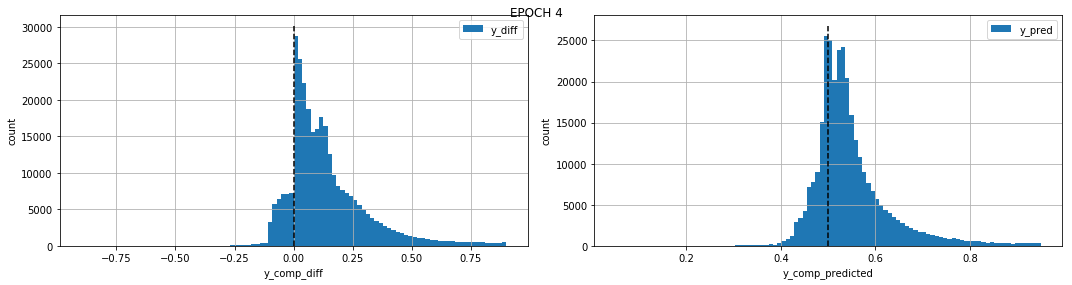

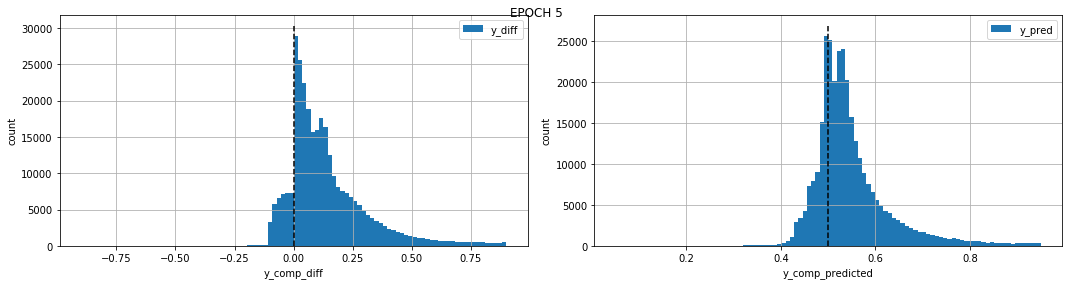

In [64]:
a = 0.9
for epoch in y_comp_pred_data.keys():
    plt.figure(figsize=[15,4])
    plt.suptitle('EPOCH {:d}'.format(epoch))
    y_diff = y_comp_diff_data[epoch]
    y_pred = y_comp_pred_data[epoch]
    
    plt.subplot(1,2,1)
    counts, bins, _ = plt.hist(y_diff, label='y_diff', alpha=1, bins=100, range=[-a, +a], stacked=False, histtype='stepfilled')
    plt.plot([0,0], plt.ylim(), 'k--')
    plt.grid()
    plt.legend()
    plt.xlabel('y_comp_diff')
    plt.ylabel('count')

    plt.subplot(1,2,2)
    counts2, bins2, _ = plt.hist(y_pred, label='y_pred', alpha=1, bins=100, range=[0.5-a/2, 0.5+a/2], stacked=False, histtype='stepfilled')
    plt.plot([0.5,0.5], plt.ylim(), 'k--')
    plt.grid()
    plt.legend()
    plt.xlabel('y_comp_predicted')
    plt.ylabel('count')
    
    plt.tight_layout()
    
    plt.show()

In [ ]:
def create_submission_table(X, y, id_table):
    out = X[['matchId', 'groupId']]
    out['winPlacePerc'] = y
    out = id_table.merge(out, on=['matchId', 'groupId'])
    out = out.drop(columns=['groupId', 'matchId'])
    return out

submission = create_submission_table(test, test['winPlacePerc'], test_ids)
submission.to_csv('submission.csv', index=False)
submission.head(50)

In [ ]:
submission.shape